### Características de la Señal

>Como es usual consta de un patrón de pulsos modulados con una portadora, enviados en forma repetitiva.<br>
>La portadora tiene un periodo de 17.48 uS. (57.2 KHz) y un ciclo de trabajo de 33.37 %.<br>
>El patrón contiene 17 pulsos.<br>
>El periodo de repetición entre los patrones es de  : 77.386 ms.<br>
>Salvo los dos primeros pulsos del patrón, el periodo activo de la portadora es siempre de : 303 $\mu s = 17$ ciclos de la portadora.


### Síntesis del Patrón
Para ser independiente del formato, el microcontrolador genera el patron de pulsos directamente de la estructura de tiempos, abstrayendose de su significado o valor :

[Num_Patterns] [Pattern_Period] [Carrier_High] [Carrier_Low] [T_High_1] [T_Low_1] ... [T_High_n] [T_Low_n]

Num_Patterns, Número de repeticiones del patrón, se expresan en 1000 Tcy.

Carrier_High y Carrier low se expresan en Tcy.

T_High_n, T_Low_n se expresan en el periodo de la portadora (Carrier_High + Carrier_Low), i.e. el número de pulsos de la portadora.


In [59]:
# Los módulos de soporte son los estándar, ...
%pylab inline
import matplotlib.pyplot as plt
from scipy.signal import *
from IPython.display import Math
import collections

# Cambia el tamaño de los gráficos, para ocupar todo el ancho de la página:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5

# Fuente del título de los gráficos :
title_font =  {'color':'darkblue', 'weight':'bold', 'style':'italic', 'size': 18}
text_font = {'color':'darkred','style':'italic', 'size': 11}

def ReadRigolCSV(filename) :
  """

  ReadSimCSV(filename) : Lee el archivo filename en el formato es CSV, resultado 
  de la captura del Osciloscopio Rigol 1052E, realiza la conversión del texto y 
  devuelve el resultado como  una tupla de los vectores de tiempo y tensión
  """
  import csv
  
  with open(filename,'r') as f :
    reader = csv.reader(f)
    
    next(reader) # get rid of headers
    next(reader)
        
    data = None
    for row in reader :
      if data is None : 
        data = [list() for i in row if i != '']
        
      for i in range(len(data)) :
        if row[i] != '' :
            data[i].append(float(row[i]))
            
  return (array(col) for col in data)
        
        
def maxFrec_of(x_val, x_count, lim_sup, lim_inf) :
  """ 
  Determina el valor de x_val cuaya correspondiente frecuencia (x_count) es la 
  mayor de los valores que se encuentran en el rango lim_inf < x_val < lim_sup
  """
  cond = (x_val < lim_sup) & (x_val > lim_inf)
  return (x_val[np.nonzero((x_count == max(x_count[np.nonzero(cond)])) & cond)])[0]  


def threshold_of(x) :
  """
  Calcula un valor optimizado para inferir la excitación de la señal x generada en 
  diodo emisor.
  """
  # La señal infroraja obtenida del diodo no es una onda cuadrada ideal, contiene ruido
  # y distorción en toda su extensión, pero particularmente distorsión en el flanco 
  # negativo, la cual puede ocasionar un error grueso  en el calculo del ciclo de trabajo 
  # de la portadora y en menor medida en el computo de tiempos del patrón infrarrojo.
    
  # la forma de la onda es tal que los flancos positivo y negativo, son practicamente 
  # exactos en los límites del estado alto (exitación activa). Por lo tanto el umbral
  # 'óptimo' sería el valor menos probable (de menor frecuencia) en la vecindad del 
  # estado alto.

  # Se calcula la distribución de los valores de las muestras ...
  from scipy import stats
  x_val, x_count = stats.find_repeats(array(x))
    
  # La polaridad de la señal estará determinada por cual de los valores de mayor frecuencia
  # (i.e. el estado de reposo o bajo) es inferior (polaridad positiva) o superior (negativa)
  # al promedio de sus valores pico (xm_peak), y se corrige para procesar una señal de
  # polaridad positiva :
  xm_peak = 0.5*(max(x_val) + min(x_val))
  if (x_val[np.nonzero(x_count == max(x_count))] > xm_peak) :
   # x = -x
    x_val = -x_val
    xm_peak = -xm_peak
    
  # El valor promedio del estado alto es el de mayor frecuencia cuyo valor es mayor que 
  # el promedio de sus valores pico :
  x_high = maxFrec_of(x_val, x_count, max(x_val), xm_peak)
    
  # similar razonamiento se aplica al lado bajo :
  x_low = maxFrec_of(x_val, x_count, xm_peak, min(x_val))
   
  # Se calcula el valor de mayor frecuencia entre los valos alto y bajo de la señal .. 
  # excluyendo la vecindad de estos :
  x_mid = maxFrec_of(x_val, x_count, x_high - 0.2*(x_high-x_low), x_low + 0.2*(x_high-x_low))
  
  # Finalmente como umbral se toma el valor medio del valor alto y el intermedio de mayor
  # frecuencia :
  x_th = 0.5*(x_high + x_mid) 
    
  return x_th
  
    


#TO DO 
# Compara/Verifica solo si existen dos patrones, 
# Se deben poder verificar mas de dos patrones 
# El ploteo de la señal debe ser comparado con el de la generada 
# Las capturas deben ser positivas (el periodo de repsoso es de 0V, los periodos de portadora 
# activa se inician con un flanco positivo)

class DecoSignal(object) :
  """
  (1) La señal debe ser positiva,   
  (2) Debe contener dos patrones.
  """
  #Tcy = 0.125e-6
  #Carrier_Period = 17.48e-6
       
  def __init__(self, filename, id = None, source = "DECODIFICADOR MOVISTAR") :
    import os
    
    if id is None :
        self.id = os.path.splitext(os.path.basename(filename))[0]
    
    self.source = source
    
    self.t, self.V = ReadRigolCSV(filename)

    # Calcula los índices de los  Flancos Positivos y Negativos de la Señal :
    self.v_threshold = threshold_of(self.V)
    i_pos = np.nonzero((self.V[1:] >= self.v_threshold) & (self.V[:-1] < self.v_threshold))[0] + 1
    i_neg = np.nonzero((self.V[1:] <= self.v_threshold) & (self.V[:-1] > self.v_threshold))[0] + 1

    # Calcula los periodos activos y de reposo de la señal :
    self.t_high = self.t[i_neg] - self.t[i_pos]
    self.t_low  = self.t[i_pos[1:]] - self.t[i_neg[:-1]]

    # El periodo alto de la señal es constante y es una característica de la portadora
    # se filtran algunos periodos anómalos (demasiado cortos posiblemente generados falta 
    # de concordancia entre la duración del pulso del patrón y la portadora) :
    self.T_CarrierHigh = self.t_high[np.nonzero(self.t_high > 0.8 *self.t_high.mean())].mean()

    # El periodo bajo de la señal es variable, se distinguen dos casos : (a) es el periodo
    # de reposo de la portadora y (b) es el periodo bajo del patrón. Se distinguen por la 
    # duración y por su frecuencia, siendo la de la protadora la predominante :
    self.T_CarrierLow = self.t_low[np.nonzero(self.t_low < 1.2 *self.t_low.mean())].mean()

    # Calcula el periodo de la portadora y su ciclo de trabajo :
    self.T_Carrier = self.T_CarrierHigh + self.T_CarrierLow
    self.DT_Carrier = self.T_CarrierHigh / self.T_Carrier

    # Flancos de la señal correspondientes al a a los Patrones de Pulsos en ella.
    #   - El primer flanco siempre es el primer flanco positivo.
    #   - Los flancos restantes son los correspondientes a los flancos que definen
    #     los lìmites de los periodos de reposo del patrón. 
    t_pattern = [self.t[i_pos[0]]]
    for n in np.nonzero(self.t_low > 2*self.T_CarrierLow)[0] :
        t_pattern = t_pattern + [self.t[i_neg[n]] , self.t[i_pos[n+1]]]    
    t_pattern = np.array(t_pattern)
    
    # Calcula la temporización del Patrón o Patrones de de Pulsos en la captura :
    t_pattern = t_pattern[1:] - t_pattern[:-1]

    # La captura de la señal puede incluir mas de un patrón, por lo que se separan, reconociendo
    # el intervalo mas largo :
    # TO DO : El intervalo mas largo debe ser bastante mayor que los restantes.
    i_interPattern = np.append([-1] , np.nonzero(t_pattern > 0.8*t_pattern.max()))
    self.t_patterns = []

    for start, stop in zip(i_interPattern[:-1], i_interPattern[1:]) :
      self.t_patterns.append(t_pattern[start+1 : stop+1]) 

    # Verificación de la captura :
    pattern_lengths = [len(p) for p in self.t_patterns] 
    if np.nonzero(pattern_lengths != pattern_lengths[0])[0] :
      print("Los patrones de la captura son de diferente longitud.")
      return 
    
    self.pattern_avg = [array(x).mean() for x in zip(* self.t_patterns)]
    pattern_err = np.array([x/self.pattern_avg - 1 for x in self.t_patterns])
    
    if np.nonzero(abs(pattern_err) > 0.02)[0].size > 0 :
      print("Los patrones capturados discrepan en la temporización por mas de 2%")
  
        
  def xmlDescriptor(self, Tcy = 1/32e6, save = False) :
    """
    Genera y Devuelve una cadena de texto con la descripción del patrón detectado, 
    si save es una cadena de caracteres (no vacia) se almacena la descripción en un
    archivo con el nombre save, si save es True se salva a un archivo con el nombre
    del identificador (aka. self.id)
    """
    import os
    
    # Como el patron ha sido calculado midiendo la diferencia de tiempo entre los flancos
    # límites de cada periodo, a los periodos de portadora activa (aka los impares) debe 
    # agregarse el intervalo de reposo de la misma portadora, mientras que a los periodos 
    # de repsoso se les debe restar el mismo periodo de reposo de la portadora, antes de 
    # calcular su duración en el número de ciclos de la portadora :
    carrierlow_time = (1 - self.DT_Carrier)*self.T_Carrier 
    num_pulses = int(len(self.pattern_avg) / 2)
    delta = carrierlow_time*array([(a,b) for a,b in zip(ones(num_pulses), -ones(num_pulses))]).flatten()
    
    # Se calcula el periodo en el Numero de ciclos 
    pattern = np.rint((self.pattern_avg + delta )/ self.T_Carrier)
        
    str = """<?xml version="1.0" encoding="UTF-8"?>\n"""
    str = str + "<IR_CODE>\n"
    
    str = str + """   <SOURCE>
       %s
   </SOURCE>\n""" %self.source
    
    str = str + """
   <ID>
       %s
   </ID>\n""" %self.id
   
    str = str + """
   <CARRIER unit = "%e seg"> 
      <PERIOD> %d </PERIOD>
      <DUTY_CYCLE> %d </DUTY_CYCLE>
   </CARRIER>\n\n""" %(Tcy, round(self.T_Carrier/Tcy), round(self.T_Carrier*self.DT_Carrier/Tcy))

    str = str + """   <PATTERN type="array" unit="CARRIER_PERIOD">\n"""
          
    for high, low in zip(pattern[::2], pattern[1::2]) :
      str = str + """
       <PULSE> 
         <HIGH> %d </HIGH>
         <LOW> %d </LOW>
       </PULSE>\n""" %(high, low)
        
    str = str + """\n   </PATTERN>
</IR_CODE>"""
    
    if (save) and ((type(save) == str) or (type(save) == bool)) :
      if type(save) == bool : 
        file = open("%s.xml" % self.id, "w")
      else :
        file = open(save, "w")

      file.write(str)
      file.close()
        
    return str     
            
  def plotPattern(self) :
    plt.figure(figsize=(16,6))
    plt.grid(True)
    plt.xlabel('t (mseg.)')
    plt.ylabel(r'$V_d$',fontdict={'family':'serif', 'color':'darkred', 'weight':'normal', 'size':'12'})

    # Calcula la posición de los flancos :
    pattern = np.concatenate(([0],self.pattern_avg))
    t = sum(np.tri(len(pattern)) * pattern, 1)
    
    # Como en cada flanco la señal es bivalente, i.e. cambia de estado, se duplican las 
    # cooerdenadas de tiempo ...
    #t = np.concatenate(zip(t,t))
    t = np.repeat(t,2)[:-1]
    
    # y se asigna a cada coordenada de tiempo el valor de la señal, notese que la señal 
    # cambia de estado cada dos índices, La señal se escala entre [0.2, 0.8] para centrarla
    # en el gráfico :
    v = 0.6*np.array([(int((n+1)/2)%2) for n in arange(len(t))]) + 0.2

    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.plot(t, v)
    
    plt.show()
    
    return plt          
  
  def plot(self, t1 = None, t2 = None, Vth = None) :
    start = 0 if t1 is None else np.argmax(self.t >= t1)
    stop  = (len(self.t)- 1) if t2 is None else np.argmax(self.t > t2)
    window = slice(start, stop)
    
    plt.figure(figsize=(16,6))
    plt.grid(True)
    plt.xlabel('t (mseg.)')
    plt.ylabel(r'$V_d$',fontdict={'family':'serif', 'color':'darkred', 'weight':'normal', 'size':'12'})

    plt.plot(self.t[window]*1000, self.V[window])
    if not Vth is None : plt.plot(self.t[window]*1000, Vth*ones(window.stop - window.start), 'r')
    plt.show()
    
    return plt
        
def std_plot(xlabel = "t(mseg.)", ylabel = "$V_d$" ) :
    plt.figure(figsize=(16,6))
    plt.grid(True)
    plt.xlabel(xlabel, fontdict={'family':'serif', 'color':'darkred', 'weight':'normal', 'size':'12'})
    plt.ylabel(ylabel ,fontdict={'family':'serif', 'color':'darkred', 'weight':'normal', 'size':'12'})
    
    return plt     



Populating the interactive namespace from numpy and matplotlib


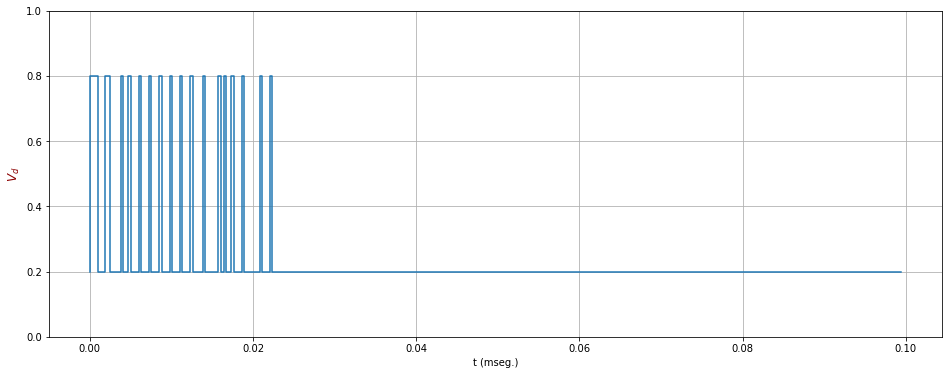

<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [60]:
s = DecoSignal("capturas/K0.csv")
s.plotPattern()


In [62]:
xml = s.xmlDescriptor(1/32e6, save = True)
print(xml)


<?xml version="1.0" encoding="UTF-8"?>
<IR_CODE>
   <SOURCE>
       DECODIFICADOR MOVISTAR
   </SOURCE>

   <ID>
       K0
   </ID>

   <CARRIER unit = "3.125000e-08 seg"> 
      <PERIOD> 559 </PERIOD>
      <DUTY_CYCLE> 186 </DUTY_CYCLE>
   </CARRIER>

   <PATTERN type="array" unit="CARRIER_PERIOD">

       <PULSE> 
         <HIGH> 55 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 36 </HIGH>
         <LOW> 72 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 36 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
         <HIGH> 18 </HIGH>
         <LOW> 54 </LOW>
       </PULSE>

       <PULSE> 
 

In [26]:
# Genera las especificaciones de las teclas :

file_list = ['Back.csv', 'CH-Minus.csv', 'Info.csv', 'Up.csv', 'Vol-Minus.csv', 'Vol-Plus.csv']
for f in file_list :
    DecoSignal('capturas/' + f).xmlDescriptor(1/32e6, save = True)
    